Start with our usual setup, including the utility methods from last time.

In [45]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from time import time

# Make matplotlib figures appear inline in the
# notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def lin_map(val, r_src, r_dst):
    percent = (val - r_src[0]) / (r_src[1] - r_src[0])
    return percent * (r_dst[1] - r_dst[0]) + r_dst[0]

def clamp_range(img):
    min_ = min(img.flatten())
    max_ = max(img.flatten())

    # Apparently this code is generic enough to handle multidimensional arrays?
    return lin_map(img, [min_, max_], [0., 1.])

def difference(a, b):
    return np.abs((a / 255. - b / 255.))

def display(img, title=None):
    # Show image
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

First, we're going to explore the Gaussian kernel. You may need to run `pip3 install opencv-python` and restart Jupyter notebook.

In [46]:
import cv2
filter = cv2.getGaussianKernel(5, 1)

As we might expect, this returns a 1x5 Gaussian kernel, where the standard deviation is 1. We can use two of these kernels to create a 2d filter, or we can use the higher level function GaussianBlur. Let's try that next. We'll compare the output of the Gaussian blur filter to the simple moving average blur filter we learned about earlier.

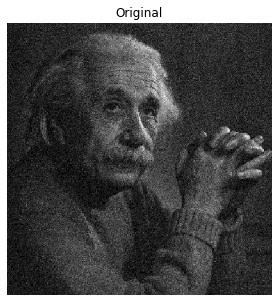

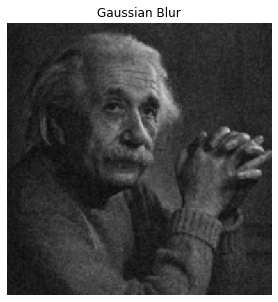

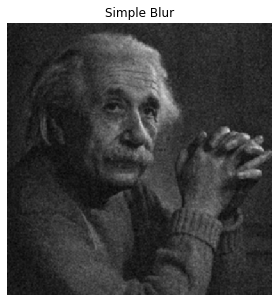

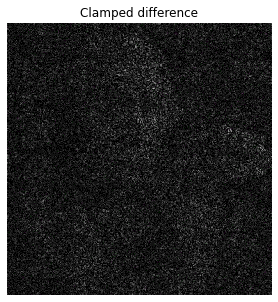

In [47]:
image = cv2.imread('./noisy_einstein.png')
display(image, "Original")

blur_image = cv2.GaussianBlur(image, (11,11), 1)
display(blur_image, "Gaussian Blur")

simple_blur_filter = np.array(
[
    [.11,.11,.11],
    [.11,.11,.11],
    [.11,.11,.11],
])
simple_blur_image = cv2.filter2D(image, -1, simple_blur_filter)
display(simple_blur_image, "Simple Blur")
display(clamp_range(difference(blur_image, simple_blur_image)), "Clamped difference")

# Exercise 1

Recall from lecture that the two parameters to Gaussian blur are kernel size and sigma. How do changing these parameters affect the output of the blur filter? You may want to find a different example image to illustrate your point.

In [48]:
from skimage import feature, data

image = data.coins()

def canny_annotated(sigma, low_threshold, high_threshold, target=image):
    display(feature.canny(target, sigma, low_threshold, high_threshold), f"Canny sigma={sigma}, low_threshold={low_threshold}, high_threshold={high_threshold}")

First, let's look at the effect of `sigma`. Intuitively, as this goes up, we'll start losing small edges which may either be artifacts such as noise (which would be desirable to remove) or image details such as the edges on the coin faces (which would be potentially undesirable to remove).

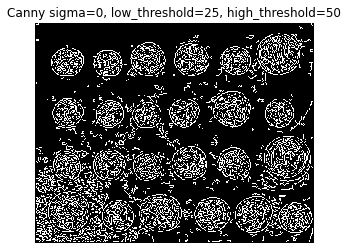

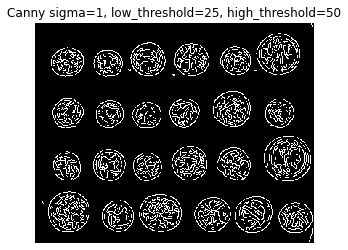

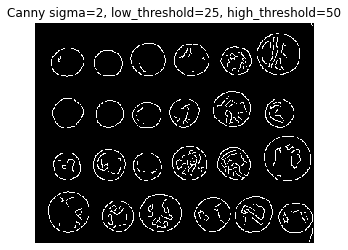

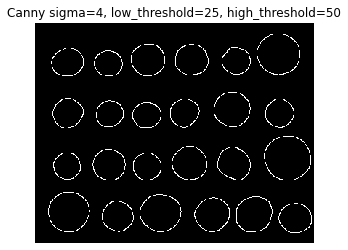

In [49]:
canny_annotated(sigma=0, low_threshold=25, high_threshold=50)
canny_annotated(sigma=1, low_threshold=25, high_threshold=50)
canny_annotated(sigma=2, low_threshold=25, high_threshold=50)
canny_annotated(sigma=4, low_threshold=25, high_threshold=50)

# Exercise 2

1. Play with the thresholds to get different output. How does changing each threshold affect the edges that the algorithm finds?
2. Imagine that you have an image with lots of false positives: that is, it finds lots of edges that aren't actually edges. How would you adjust thresholds to improve the result?
3. Imagine that you have an image where the edges don't connect well: that is, it finds some edges, but the edges tend to be broken lines instead of solid lines. How would you adjust thresholds to improve the result?
5. Remember from exercise 1 that the two parameters to the Gaussian blur are kernel size and sigma, and that both affect the output of the blur filter. Notice that skimage's canny implementation only takes sigma as a parameter. Without modifying the source code, how might you incorporate a different kernel size into the implementation?
4. Try to improve the edges you find by tweaking the parameters. 
5. Try running the edge detector on some different images. skimage.data has a good set to start with. You can also look at [Berkeley's collection of benchmark images](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/). Take notes on which images Canny performs well on, and which it does not.




In [ ]:
# TODO

# Hough Transform

In this exercise, we'll explore how edge detection and line-finding can be used to implement part of a self-driving car algorithm.

We'll start with the steps we covered in lecture: find the edges and then find the lines.

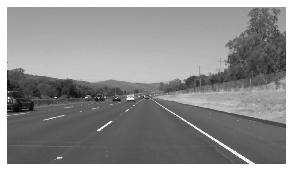

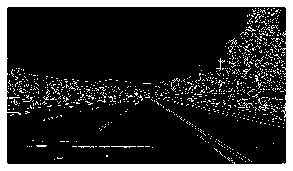

In [51]:
image = cv2.imread('./road.jpg', flags=cv2.IMREAD_GRAYSCALE)

display(image)
edge_image = feature.canny(image, sigma=1, low_threshold=10, high_threshold=30)
display(edge_image)

We'll use the probabilistic hough transform function, as it's a bit easier to work with.

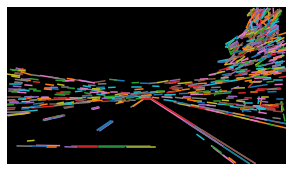

In [52]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(edge_image, threshold=1, line_length=20,
                                 line_gap=5)

plt.figure(figsize = (5,5))
plt.imshow(edge_image * 0)
plt.axis('off')
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))


# Exercise 3

1. We've found some lines. Lots of them, in fact. Using only the techniques we've learned so far, how can we clean up this image to only show the lines that correspond to lanes? Optional: implement some of them and show the improvement in the produced image.

2. We can also use additional information that we have about the image; namely, we know that our images are always coming from a camera mounted on the front of the car. How could we use this information to improve on our lane-finding algorithm? Optional: implement your suggestion and show the improvement in the produced image.

3. A video is just a series of images (usually 30 images per second). Imagine that your lane-finding algorithm is being fed a video from a front-mounted camera. Describe how you would use your lane-finding algorithm to keep the car driving straight and in its lane.

In [52]:
# TODO

# Dead Code

Scrapped code I ended up not using.

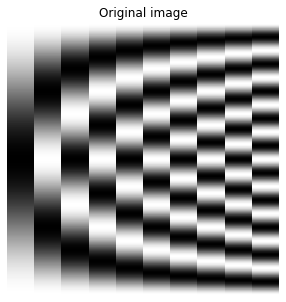

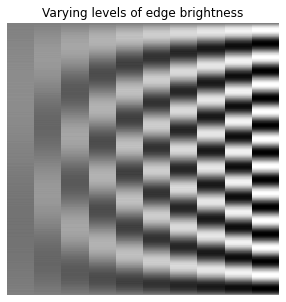

In [53]:
edges_image = np.zeros([500, 500])
tau = 2 * np.pi

horizontal_divides = 10
periods_per_divide = 1

# We use y, x indexing because display takes in images as arrays of rows.
for y, x in np.ndindex(edges_image.shape):
    # Normalize coordinates between 0 and 1.
    [u, v] = np.array([x, y]) / edges_image.shape

    # Get the number of periods in the horizontal slice.
    periods = np.floor(u * horizontal_divides) + 1
    edges_image[y, x] = int(np.cos(periods_per_divide * periods * v * tau) * 255)

derivative_filter = 2. * np.array(
[
    [0,1,0],
    [0,0,0],
    [0,-1,0]
])

display(edges_image, "Original image")
display(clamp_range(cv2.filter2D(edges_image, -1, derivative_filter)), "Varying levels of edge brightness")

In [ ]:
drawing_img = cv2.imread("my-first-drawing.png", cv2.IMREAD_GRAYSCALE)

display(drawing_img, "Riley's first drawing")

def canny_sobel(target):
    jsobel = ndi.sobel(target, axis=1)
    isobel = ndi.sobel(target, axis=0)
    magnitude = np.hypot(isobel, jsobel)
    return magnitude

def canny_threshold_debug(target, low, high):
    target_edges = canny_sobel(target)
    display(target_edges, f"Sobel debug (low={low}, high={high})")

    debug_img = np.zeros(target_edges.shape)

    for y, x in np.ndindex(debug_img.shape):
        brightness = target_edges[y, x]
        if brightness < low:
            debug_img[y, x] = 0
        elif brightness < high:
            debug_img[y, x] = 127
        else:
            debug_img[y, x] = 255

    display(debug_img, f"Canny threshold debug (low={low}, high={high})")
    display(
        feature.canny(image=target, sigma=0, low_threshold=low, high_threshold=high),
        f"Canny (low={low}, high={high})"
    )

canny_threshold_debug(drawing_img, 40, 50)